In [66]:
#These dictionaries describe the local hour of the satellite
local_times = {"aquaDay":"13:30",
               "terraDay":"10:30",
               "terraNight":"22:30",
               "aquaNight":"01:30"
              }
# and are used to load the correct file for dealing with the date-line.
min_hours = {"aquaDay":2,
            "terraDay":-1,
            "aquaNight":-1,
            "terraNight":11}
max_hours = {"aquaDay":24,
            "terraDay":22,
            "aquaNight":13,
            "terraNight":24}

In [67]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [111]:
#Data loader for the satellite data,
#returns a complete global map (regular lat-lon)
#but sparsely filled, with only one stripe of data
#showing where the satellite passed that hour
def get_satellite_slice(date : str,
                        utc_hour : int,
                        satellite='aquaDay',
                        latitude_bound = None #Recommend only using |lat| < 70 degrees
                       ):
    #Due to crossing of the datetime, some times will be saved different date
    if utc_hour < min_hours[satellite]:
        file_date = str((np.datetime64(date) - np.timedelta64(1,'D')))
    elif utc_hour > max_hours[satellite]:
        file_date = str((np.datetime64(date) + np.timedelta64(1,'D')))
    else:
        file_date = date
        
    #print ('the UTC hour is', utc_hour)
    #print ('the file date is', file_date)
    #Open .tif file
    sat_xr = xr.open_rasterio(f'{satellite_folder}/{satellite}_errorGTE03K_04km_{file_date}.tif')
    #Rename spatial dimensions
    sat_xr = sat_xr.rename({'x':'longitude','y':'latitude'})
    
    #Create time delta to change local to UTC
    time_delta = pd.to_timedelta(sat_xr.longitude.data/15,unit='H') 
    
    #Convert local satellite time to UTC and round to nearest hour
    time = (pd.to_datetime([file_date + " " + "13:30"]*time_delta.shape[0]) - time_delta).round('H')
    
    #display(time)
    #print(time)
    #Select desired hour
   
    dt = np.datetime64(f'{date} {utc_hour:02}:00:00')
    right_time = np.expand_dims(time == dt,axis=(0,1))
    
    
    #print ('right time', right_time.sum())
    if right_time.sum() == 0:
        print("Warning: Correct time not found in dataset, likely problem in file selection")
    #Make subset
    subset = np.logical_and(np.isfinite(sat_xr),right_time)
    if subset.sum() == 0:
        print(f"Warning: No valid data found for {date} {utc_hour:02}h")
    if latitude_bound is not None:
        #print(f"Subsetting < {latitude_bound}")
        subset = np.logical_and(subset,np.expand_dims(np.abs(sat_xr.latitude) < latitude_bound,axis=(0,-1)))
    #Select valid data
    test_subset = sat_xr.where(subset).load()
    sat_xr.close()
    sat_xr = None
    #display(test_subset)
    #display(test_subset[0,::-1,:])
    #display(test_subset.squeeze('band'))
    
    
    return test_subset[0,::-1,:]

In [113]:
satellite_folder = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
test_data = get_satellite_slice('2018-01-03',11,latitude_bound=70)

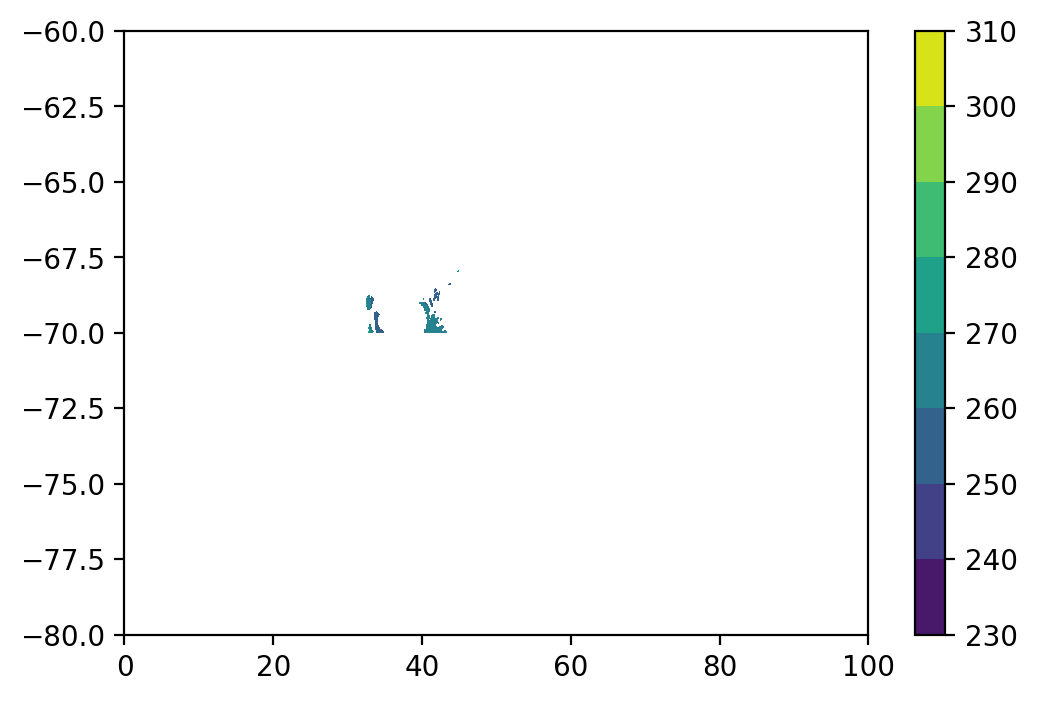

In [116]:
plt.figure(dpi=200)
#Make grid for plotting purposes
xv, yv = np.meshgrid(test_data.longitude, test_data.latitude, indexing='xy')
#Contour plot
plt.contourf(xv,yv,test_data,levels=np.arange(230,320,10))
plt.xlim(0,100)
plt.ylim(-80,-60)


plt.colorbar()

In [18]:
blob = [True,False]

In [20]:
sum(blob)

1

In [39]:
def get_era_data(date : str,
                 utc_hour : int,
                 field = 't2m'):

    print ('date = ', '_'.join(date.split('-')))
    month = '_'.join(date.split('-')[:-1])
    
    print ('month', month)
    
    ds_era = xr.open_dataset(f'{era_folder}/sfc_unstructured_{month}.grib',engine='cfgrib')
    #Grab correct field
    da = ds_era[field]
    #
    time_str = f"{date} {utc_hour:02}:00:00" 
    print (time_str)
    da = da.sel(time=time_str)
    #Relabel longitude coordinate to be consistent with MODIS
    da = da.assign_coords({"longitude": (((da.longitude + 180) % 360) - 180)})
    
    #Load data, perhaps this is too early?
    da = da.load()
    
    #Close file, attempt to not have memory leaks
    ds_era.close()
    ds_era = None
    return da

In [40]:
era_folder = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
da = get_era_data('2019-01-01',10)

Ignoring index file '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw//sfc_unstructured_2019_01.grib.923a8.idx' incompatible with GRIB file


date =  2019_01_01
month 2019_01
2019-01-01 10:00:00


---

In [94]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
f = 'aquaDay_errorGTE03K_04km_2019-01-01.tif'

sat_xr = xr.open_rasterio(root+f) #load the temperature data array

In [95]:
sat_xr = sat_xr.rename({'x':'longitude','y':'latitude'})

In [96]:
time_delta = pd.to_timedelta(sat_xr.longitude.data/15,unit='H') 

In [99]:
file_date = '2019-01-01'
local_times = "13:30"
time = (pd.to_datetime([file_date + " " + local_times]*time_delta.shape[0]) - time_delta).round('H')

In [100]:
time

DatetimeIndex(['2019-01-02 01:00:00', '2019-01-02 01:00:00',
               '2019-01-02 01:00:00', '2019-01-02 01:00:00',
               '2019-01-02 01:00:00', '2019-01-02 01:00:00',
               '2019-01-02 01:00:00', '2019-01-02 01:00:00',
               '2019-01-02 01:00:00', '2019-01-02 01:00:00',
               ...
               '2019-01-01 02:00:00', '2019-01-01 02:00:00',
               '2019-01-01 02:00:00', '2019-01-01 02:00:00',
               '2019-01-01 02:00:00', '2019-01-01 02:00:00',
               '2019-01-01 02:00:00', '2019-01-01 02:00:00',
               '2019-01-01 02:00:00', '2019-01-01 02:00:00'],
              dtype='datetime64[ns]', length=10800, freq=None)

In [101]:
#Select desired hour
date = '2019-01-01'
utc_hour = 10
dt = np.datetime64(f'{date} {utc_hour:02}:00:00')
right_time = np.expand_dims(time == dt,axis=(0,1))
if right_time.sum() == 0:
    print("Warning: Correct time not found in dataset, likely problem in file selection")
#Make subset
subset = np.logical_and(np.isfinite(sat_xr),right_time)

In [102]:
subset

<xarray.DataArray (band: 1, latitude: 5400, longitude: 10800)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * band       (band) int64 1
  * latitude   (latitude) float64 89.98 89.95 89.92 ... -89.92 -89.95 -89.98
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    transform:      (0.03333333333333333, 0.0, -180.0, 0.0, -0.03333333333333...
    crs:            +init=epsg:4326
    res:            (0.03333333333333333, 0.03333333333333333)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('LST_Day_1km',)
    AREA_OR_POINT:  Area